In [1]:
import pandas as pd
import pickle

from review_tools import extract_review, lemmatize

In [2]:
with open('df_with_patch_object.pickle', 'rb') as f:
    patch_responses = pickle.load(f)

In [3]:
def get_changed_lines(Patch):
    try:
        return Patch.diff.lines
    except:
        return None
    
def get_num_patches(Patch):
    try:
        return len(Patch.diff.patches)
    except:
        return None

In [4]:
patch_responses['lines'] = patch_responses['Patch'].map(get_changed_lines)
patch_responses['num_patches'] = patch_responses['Patch'].map(get_num_patches)

In [5]:
patch_responses.sort_values('lines', ascending=False).head()

,Unnamed: 0,patch_id,response_author,resp_parent,resp_msg_id,upstream,response_is_bot,bot_name,patch_author,responder,self_response,email,Patch,lines,num_patches
163412,163412,<20200601182926.1267958-1-alexander.deucher@am...,Alex Deucher <alexdeucher@gmail.com>,<20200601182926.1267958-1-alexander.deucher@am...,<20200601182926.1267958-13-alexander.deucher@a...,NaN,False,NaN,"('alex deucher', 'alexdeucher@gmail.com')","('alex deucher', 'alexdeucher@gmail.com')",True,"[Return-Path, X-Spam-Checker-Version, X-Spam-L...",<pypasta.Repository.Mbox.PatchMail object at 0...,9048.0,10.0
106683,106683,<20200106234703.645168-1-matthew.auld@intel.com>,Chris Wilson <chris@chris-wilson.co.uk>,<20200106234703.645168-1-matthew.auld@intel.com>,<20200107134009.3255354-1-chris@chris-wilson.c...,NaN,False,NaN,"('matthew auld', 'matthew.auld@intel.com')","('chris wilson', 'chris@chris-wilson.co.uk')",False,"[Return-Path, X-Spam-Checker-Version, X-Spam-L...",<pypasta.Repository.Mbox.PatchMail object at 0...,8978.0,23.0
54073,54073,<20190715080946.15593-1-chris@chris-wilson.co.uk>,Chris Wilson <chris@chris-wilson.co.uk>,<20190715080946.15593-1-chris@chris-wilson.co.uk>,<20190715080946.15593-24-chris@chris-wilson.co...,NaN,False,NaN,"('chris wilson', 'chris@chris-wilson.co.uk')","('chris wilson', 'chris@chris-wilson.co.uk')",True,"[From, Subject, Date, Message-ID, References, ...",<pypasta.Repository.Mbox.PatchMail object at 0...,8346.0,37.0
19363,19363,<20191206210612.8676-2-jolsa@kernel.org>,"""tip-bot2 for Jiri Olsa"" <tip-bot2@linutronix.de>",<20191206210612.8676-2-jolsa@kernel.org>,<157867879735.30329.5716181221577989360.tip-bo...,NaN,True,tip-bot2@linutronix.de,"('jiri olsa', 'jolsa@kernel.org')","('tip-bot2 for jiri olsa', 'tip-bot2@linutroni...",False,"[Return-Path, X-Original-To, Delivered-To, Rec...",<pypasta.Repository.Mbox.PatchMail object at 0...,7737.0,75.0
100409,100409,<20191212093008.217086-1-Jason@zx2c4.com>,"""Jason A. Donenfeld"" <Jason@zx2c4.com>",<20191212093008.217086-1-Jason@zx2c4.com>,<20191212093008.217086-2-Jason@zx2c4.com>,NaN,False,NaN,"('jason a. donenfeld', 'jason@zx2c4.com')","('jason a. donenfeld', 'jason@zx2c4.com')",True,"[Return-Path, X-Spam-Checker-Version, X-Spam-L...",<pypasta.Repository.Mbox.PatchMail object at 0...,5733.0,6.0


In [6]:
# patch_responses.sort_values('lines', ascending=False).iloc[0].Patch.__dict__

In [7]:
author_counts = dict(patch_responses[patch_responses['patch_author'].notna()][['patch_author', 'upstream']].groupby('patch_author').nunique()['upstream'])
num_commits = patch_responses['upstream'].nunique()

def author_activity(author):
    try:
        return (author_counts[author]/num_commits)*100
    except:
        return 0
patch_responses['author_activity(%)'] = patch_responses['patch_author'].apply(author_activity)

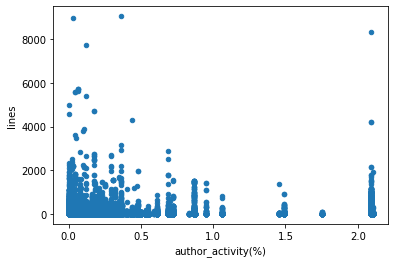

In [8]:
patch_responses.plot.scatter(x='author_activity(%)', y='lines')

In [9]:
import statistics
import lizard

# We need to provide a file name to identify the language
# i = lizard.analyze_file.analyze_source_code("AllTests.cpp", "int foo(){}")

def insert_complexity(Patch):
    if Patch:
        patches = Patch.diff.patches
        results = []
        for filename, patch in patches.items():
            for _, hunk in patch.hunks.items():
                if len(hunk.insertions):
                    function_list = \
                    lizard.analyze_file.analyze_source_code(filename[0], '\n'.join(hunk.insertions)).function_list
                    if len(function_list):
                        for function in function_list:
                            results.append(function.cyclomatic_complexity)
        if len(results):
            return statistics.mean(results)
    return None

In [10]:
patch_responses['insert_complexity'] = patch_responses['Patch'].apply(insert_complexity)

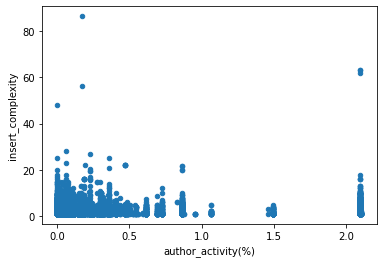

In [11]:
patch_responses.plot.scatter(x='author_activity(%)', y='insert_complexity')

In [13]:
patch_responses[patch_responses['self_response'] == False].count()

Unnamed: 0            158201
patch_id              158201
response_author       158201
resp_parent           158201
resp_msg_id           158201
upstream               17293
response_is_bot       158201
bot_name               16077
patch_author          158201
responder             158201
self_response         158201
email                 158200
Patch                   7664
lines                   7664
num_patches             7664
author_activity(%)    158201
insert_complexity       1966
dtype: int64

In [14]:
patch_responses[patch_responses['self_response'] == False & patch_responses['num_patches'].notnull()].iloc[0]

Unnamed: 0                                                            3
patch_id              <0-v1-4eb72686de3c+5062-hmm_no_flags_jgg@mella...
response_author                   Ralph Campbell <rcampbell@nvidia.com>
resp_parent           <0-v1-4eb72686de3c+5062-hmm_no_flags_jgg@mella...
resp_msg_id           <17ce2fdc-4f9f-7772-c10c-6f339a4183e8@nvidia.com>
upstream                                                            NaN
response_is_bot                                                   False
bot_name                                                            NaN
patch_author                        ('jason gunthorpe', 'jgg@ziepe.ca')
responder                    ('ralph campbell', 'rcampbell@nvidia.com')
self_response                                                     False
email                 [Return-Path, X-Spam-Checker-Version, X-Spam-L...
Patch                                                              None
lines                                                           

In [15]:
# What to exclude:
# [line for line in  patch_responses[patch_responses['self_response'] == False & patch_responses['num_patches']\
#                                    .notnull()].iloc[5]\
# .email._payload.split('\n') if line.startswith('>')]

In [16]:
review = ' '.join([line.strip() for line in  patch_responses[patch_responses['self_response'] == False & patch_responses['num_patches'].notnull()]\
 .iloc[5].email._payload.split('\n') if not line.startswith('>')])
review

"On Mon, Apr 06, 2020 at 09:44:26PM -0300, Jason Gunthorpe wrote:  Don't you need to set EPOLLHUP too? Probably, it won't change anything, just for the sake of the correctness.  Thanks, Reviewed-by: Leon Romanovsky <leonro@mellanox.com> "

In [17]:
patch_responses[patch_responses['self_response'] == False & patch_responses['num_patches'].notnull()]\
 .iloc[5].email._payload

'On Mon, Apr 06, 2020 at 09:44:26PM -0300, Jason Gunthorpe wrote:\n> From: Jason Gunthorpe <jgg@mellanox.com>\n>\n> If is_closed is set, and the event list is empty, then read() will return\n> -EIO without blocking. After setting is_closed in\n> ib_uverbs_free_event_queue(), we do trigger a wake_up on the poll_wait,\n> but the fops->poll() function does not check it, so poll will continue to\n> sleep on an empty list.\n>\n> Fixes: 14e23bd6d221 ("RDMA/core: Fix locking in ib_uverbs_event_read")\n> Signed-off-by: Jason Gunthorpe <jgg@mellanox.com>\n> ---\n>  drivers/infiniband/core/uverbs_main.c | 2 ++\n>  1 file changed, 2 insertions(+)\n>\n> diff --git a/drivers/infiniband/core/uverbs_main.c b/drivers/infiniband/core/uverbs_main.c\n> index 2d4083bf4a0487..8710a3427146e7 100644\n> --- a/drivers/infiniband/core/uverbs_main.c\n> +++ b/drivers/infiniband/core/uverbs_main.c\n> @@ -296,6 +296,8 @@ static __poll_t ib_uverbs_event_poll(struct ib_uverbs_event_queue *ev_queue,\n>  \tspin_lock_ir

In [85]:
review = patch_responses[patch_responses['self_response'] == False].iloc[3].email.get_payload()
isBase64(review)

True

In [ ]:
review

In [86]:
isBase64(review)

False

In [58]:
nltk.sent_tokenize(' '.join(review))

['Return-Path X-Spam-Checker-Version X-Spam-Level X-Spam-Status Received Received DKIM-Signature Received Received Received DKIM-Signature Date From To Cc Subject Message-ID References MIME-Version Content-Type Content-Disposition In-Reply-To Sender Precedence List-ID X-Mailing-List']

In [59]:
review = extract_review(patch_responses[patch_responses['self_response'] == False].iloc[109].email)
review

['Hi Leonard,',
 'It looks good to me. Thanks for your effort.',
 "But, I have one minor comment related to 'over 80 char'.",
 "Please edit this line as following in order to prevent the 'over 80 char'",
 'dev_warn(dev->parent,',
 '"Failed to remove DEV_PM_QOS_MAX_FREQUENCY request: %d\\n", err);',
 'dev_warn(dev->parent,',
 '"Failed to remove DEV_PM_QOS_MIN_FREQUENCY request: %d\\n", err);',
 'If you edit them, feel free to add my reviewed-by tag:',
 'Reviewed-by: Chanwoo Choi <cw00.choi@samsung.com>',
 'On 19. 10. 3. ì\x98¤ì\xa0\x84 4:25, Leonard Crestez wrote:',
 "Please edit this line as following in order to prevent the 'over 80 char'",
 'dev_warn(dev->parent,',
 '"Failed to remove DEV_PM_QOS_MAX_FREQUENCY request: %d\\n", err);',
 'ditto. Please edit this line as following:',
 'dev_warn(dev->parent,',
 '"Failed to remove DEV_PM_QOS_MIN_FREQUENCY request: %d\\n", err);',
 '--',
 'Best Regards,',
 'Chanwoo Choi',
 'Samsung Electronics',
 '___________________________________________

In [60]:
nltk.sent_tokenize(''.join(review))

['Hi Leonard,It looks good to me.',
 'Thanks for your effort.But, I have one minor comment related to \'over 80 char\'.Please edit this line as following in order to prevent the \'over 80 char\'dev_warn(dev->parent,"Failed to remove DEV_PM_QOS_MAX_FREQUENCY request: %d\\n", err);dev_warn(dev->parent,"Failed to remove DEV_PM_QOS_MIN_FREQUENCY request: %d\\n", err);If you edit them, feel free to add my reviewed-by tag:Reviewed-by: Chanwoo Choi <cw00.choi@samsung.com>On 19.',
 '10.',
 '3. ì\x98¤ì\xa0\x84 4:25, Leonard Crestez wrote:Please edit this line as following in order to prevent the \'over 80 char\'dev_warn(dev->parent,"Failed to remove DEV_PM_QOS_MAX_FREQUENCY request: %d\\n", err);ditto.',
 'Please edit this line as following:dev_warn(dev->parent,"Failed to remove DEV_PM_QOS_MIN_FREQUENCY request: %d\\n", err);--Best Regards,Chanwoo ChoiSamsung Electronics_______________________________________________linux-arm-kernel mailing listlinux-arm-kernel@lists.infradead.orghttp://lists.i

In [61]:
df_reviews = patch_responses[patch_responses['email'].notnull()][patch_responses['self_response'] == False]

<ipython-input-61-2d21ef751b50>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reviews = patch_responses[patch_responses['email'].notnull()][patch_responses['self_response'] == False]


In [62]:
df_reviews.count()

Unnamed: 0            158200
patch_id              158200
response_author       158200
resp_parent           158200
resp_msg_id           158200
upstream               17293
response_is_bot       158200
bot_name               16077
patch_author          158200
responder             158200
self_response         158200
email                 158200
Patch                   7664
lines                   7664
num_patches             7664
author_activity(%)    158200
insert_complexity       1966
dtype: int64

In [26]:
from review_tools import extract_review, get_num_sentences

df_reviews['review'] = df_reviews['email'].map(extract_review)
df_reviews['review_lines'] = df_reviews['review'].map(len)
df_reviews['review_sentences'] = df_reviews['review'].map(get_num_sentences)
df_reviews['Name'] = df_reviews['patch_author'].str.extract('\(\'(.*)\',.*')

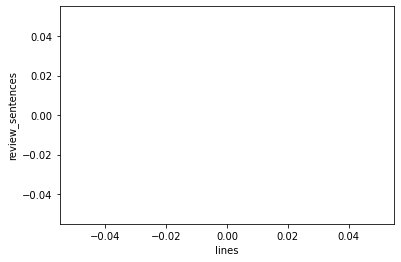

In [27]:
df_reviews.plot.scatter(x = 'lines', y = 'review_sentences')

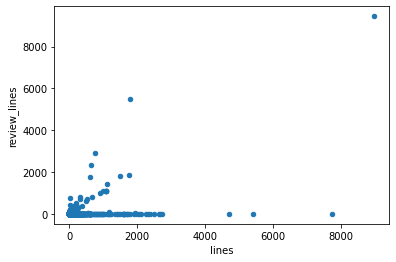

In [28]:
df_reviews.plot.scatter(x = 'lines', y = 'review_lines')

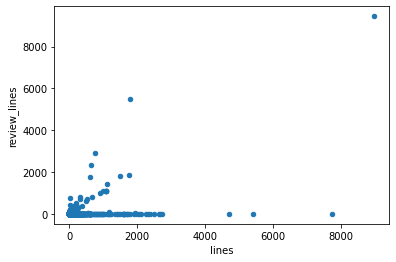

In [29]:
df_reviews.plot.scatter(x = 'lines', y = 'review_lines')

same patch id, diffrerent lines of code:

In [30]:
# patch to line dict -> reviewed num lines
patch_responses[['patch_id', 'lines']]\
                .drop_duplicates()\
                .dropna()\
                .set_index('patch_id')#.to_dict()

,lines
patch_id,
<0-v1-4eb72686de3c+5062-hmm_no_flags_jgg@mellanox.com>,39.0
<0-v1-4eb72686de3c+5062-hmm_no_flags_jgg@mellanox.com>,16.0
<0-v1-4eb72686de3c+5062-hmm_no_flags_jgg@mellanox.com>,436.0
<0-v1-4eb72686de3c+5062-hmm_no_flags_jgg@mellanox.com>,11.0
<0-v1-4eb72686de3c+5062-hmm_no_flags_jgg@mellanox.com>,12.0
...,...
<m34l02mh71.fsf@t19.piap.pl>,4.0
<m34l02mh71.fsf@t19.piap.pl>,2.0
<patch-1.thread-2257a1.git-188f5a3d81d5.your-ad-here.call-01565088755-ext-5120@work.hours>,3.0


In [31]:
developer_stats = pd.read_csv('developers_all.csv')

In [32]:
def get_active_days(line):
    try:
        return (pd.to_datetime(line['Activity End']) - pd.to_datetime(line['Activity Start'])).days
    except:
        return None

def get_num_commits(Commits):
    try:
        return int(Commits)
    except:
        return None

In [33]:
developer_stats['Active'] = developer_stats.apply(get_active_days, axis=1)
developer_stats['Name'] = developer_stats['Name'].str.lower()
developer_stats['Commits'] = developer_stats['Commits'].map(get_num_commits)
developer_stats.sort_values('Active', ascending=False).head()

,Name,Last affiliation,Activity Start,Activity End,Commits,Changed Lines,Lines Removed,Signoffs,Reviews,Test Credits,Test Credits Given,Report Credits,Report Credits Given,Active
601,ursula braun,IBM,1970-01-01,2020-07-08,373.0,19796,8463,614,142,2,1,2,41,18451.0
69,greg kroah-hartman,gregkh@linuxfoundation.org,2002-04-09,2020-08-02,4189.0,2520341,1746718,81843,524,2,87,129,516,6690.0
7528,john youn,john.youn@synopsys.com,2001-09-17,2018-03-19,139.0,8542,6588,243,0,43,22,2,11,6027.0
1812,thomas renninger,Novell,2004-09-16,2020-05-27,213.0,9906,4958,258,15,9,6,6,0,5732.0
140,thomas gleixner,linutronix,2005-01-18,2020-07-30,5051.0,308029,251087,12484,767,22,494,90,538,5672.0


In [34]:
df_reviews = pd.merge(df_reviews, developer_stats, on='Name', how='left')

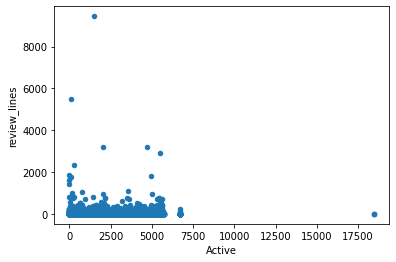

In [35]:
df_reviews.plot.scatter(x = 'Active', y = 'review_lines')

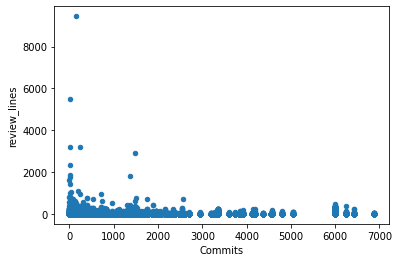

In [36]:
df_reviews.plot.scatter(x = 'Commits', y = 'review_lines')

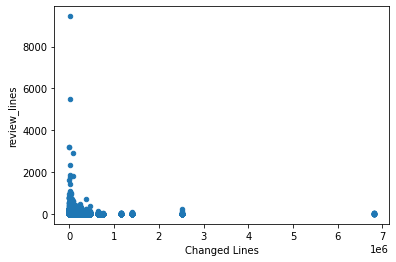

In [37]:
df_reviews.plot.scatter(x = 'Changed Lines', y = 'review_lines')

In [38]:
reviewers = df_reviews[['responder', 'resp_msg_id']].groupby('responder')\
                    .nunique()['resp_msg_id']\
                    .reset_index()\
                    .sort_values('resp_msg_id', ascending=False)

reviewers['Name'] = reviewers['responder'].str.extract('\(\'(.*)\',.*')
reviewers.drop('responder', inplace=True, axis=1)
reviewers = pd.merge(developer_stats, reviewers, on='Name', how='right')\
                    .drop(['Activity Start','Activity End'], axis=1)

In [39]:
reviewers.head()

,Name,Last affiliation,Commits,Changed Lines,Lines Removed,Signoffs,Reviews,Test Credits,Test Credits Given,Report Credits,Report Credits Given,Active,resp_msg_id
0,linus torvalds,Linux Foundation,2133.0,6808584.0,79223.0,53845.0,1.0,35.0,238.0,278.0,452.0,5591.0,134
1,alexander aring,Red Hat,654.0,26400.0,11257.0,687.0,0.0,5.0,2.0,6.0,31.0,3188.0,2
2,david teigland,Red Hat,237.0,57578.0,6929.0,413.0,0.0,4.0,1.0,14.0,6.0,4714.0,2
3,randy dunlap,rdunlap@infradead.org,2336.0,25484.0,17287.0,2572.0,74.0,117.0,11.0,566.0,104.0,5634.0,403
4,randy dunlap,rdunlap@infradead.org,2336.0,25484.0,17287.0,2572.0,74.0,117.0,11.0,566.0,104.0,5634.0,1


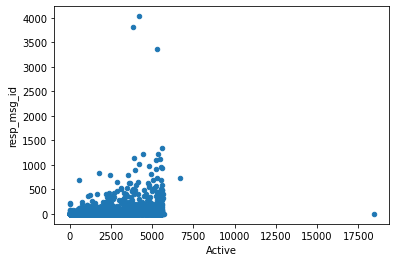

In [40]:
reviewers.plot.scatter(x= 'Active', y = 'resp_msg_id')

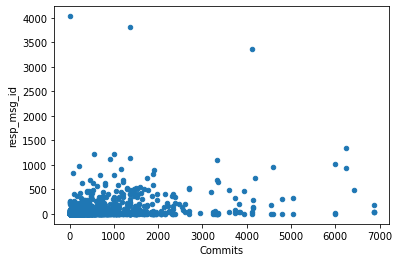

In [41]:
reviewers.plot.scatter(x= 'Commits', y = 'resp_msg_id')

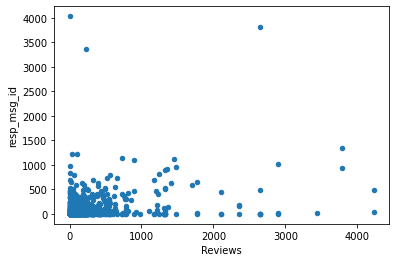

In [42]:
reviewers.plot.scatter(x= 'Reviews', y = 'resp_msg_id')